#하텍폭풍팀

팀 리더: 김성원

팀원: 
이채연
정기훈
조은남

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sktime.forecasting.naive import NaiveForecaster
import warnings
from copy import deepcopy
import xgboost as xgb

/Users/chaeyeon/miniforge3/envs/tf/lib/python3.9/site-packages/numba/cpython/hashing.py:525: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)
/Users/chaeyeon/miniforge3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Read data

In [2]:
dacon = pd.read_csv('data/train_data.csv')
sub = pd.read_csv('data/sample_submission.csv')
sub.Patv = np.nan

In [3]:
dacon = dacon.fillna(method = 'bfill')

In [4]:
dacon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4283712 entries, 0 to 4283711
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 424.9+ MB


In [5]:
dacon.tail()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
4283707,134,222,23:10,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,23:20,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,23:30,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,23:40,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92
4283711,134,222,23:50,5.36,4.86,-1.06,2.80,198.52,0.06,0.06,0.06,-50.31,337.33


In [6]:
sub.head()

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,223,00:00,0,0,0,0,0,0,0,0,0,NaN
1,1,1,223,00:10,0,0,0,0,0,0,0,0,0,NaN
2,2,1,223,00:20,0,0,0,0,0,0,0,0,0,NaN
3,3,1,223,00:30,0,0,0,0,0,0,0,0,0,NaN
4,4,1,223,00:40,0,0,0,0,0,0,0,0,0,NaN


# Evaluation function

In [7]:
def eval(y, pred):
    return ((np.sqrt(np.sum((y - pred) ** 2) / 288)) + (np.sum(np.abs(y - pred)) / 288)) / 2

# Preparing data

In [8]:
#Prepare train data (is grouped by turb id)
train_data = []
for i in tqdm(range(dacon.TurbID.max())):
    train_data.append(dacon[dacon.TurbID == i + 1].reset_index().drop(columns = ['TurbID', 'Pab2', 'Pab3','index']) )

100%|████████████████████████████████████████| 134/134 [00:00<00:00, 200.66it/s]


# ARIMA 적용

In [9]:
warnings.filterwarnings(action='ignore')
pred = []
for i in tqdm( range( len(train_data)) ):
    pred.append(ARIMA( train_data[i][(train_data[i].Wspd < 10) & (train_data[i].Day > train_data[i].Day.max() - 4)].Wspd, order = (1,0,0) ).fit().forecast(288).tolist())

100%|█████████████████████████████████████████| 134/134 [00:04<00:00, 27.55it/s]


In [10]:
patv_pred = []
for i in tqdm(range( len(train_data)) ):
    temp_data = train_data[i].loc()[ ((train_data[i].Wspd > 2.5) & (train_data[i].Patv > 0)) | (train_data[i].Wspd <= 2.5), ['Wspd','Patv'] ]
    temp_data = temp_data[(temp_data.Wspd < 11)]
    xgb_fit = xgb.XGBRegressor().fit(temp_data.Wspd, temp_data.Patv)
    patv_pred += xgb_fit.predict( np.array(pred[i]).reshape(-1,1) ).tolist()

100%|█████████████████████████████████████████| 134/134 [01:27<00:00,  1.53it/s]


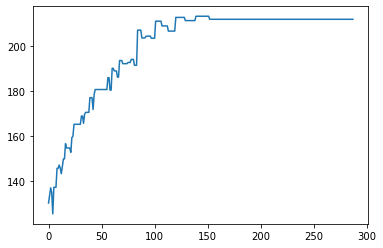

In [11]:
#첫 번째 Turbin의 예측값
plt.plot(patv_pred[0:288])

In [12]:
sub.Patv = patv_pred
sub.to_csv('sub7_4100_10,11.csv', index = False)

# EDA

In [13]:
round(train_data[1].describe(),2)

,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Prtv,Patv
count,31968.00,31968.00,31968.00,31968.00,31968.00,31968.00,31968.00,31968.00,31968.00
mean,111.50,5.70,0.78,17.29,25.50,143.05,25.97,-20.92,418.24
std,64.09,3.68,29.22,10.70,32.95,168.18,38.60,86.45,468.53
min,1.00,0.00,-169.43,-12.10,-272.96,-884.86,-10.00,-500.00,-6.61
25%,56.00,2.51,-4.16,10.45,22.49,20.08,0.01,-49.11,-0.30
50%,111.50,5.21,-0.67,20.00,30.49,93.64,0.54,-0.30,227.82
75%,167.00,8.24,2.82,25.42,35.97,265.92,83.28,-0.13,729.47
max,222.00,23.31,172.17,34.77,50.22,588.42,90.67,285.95,1545.83


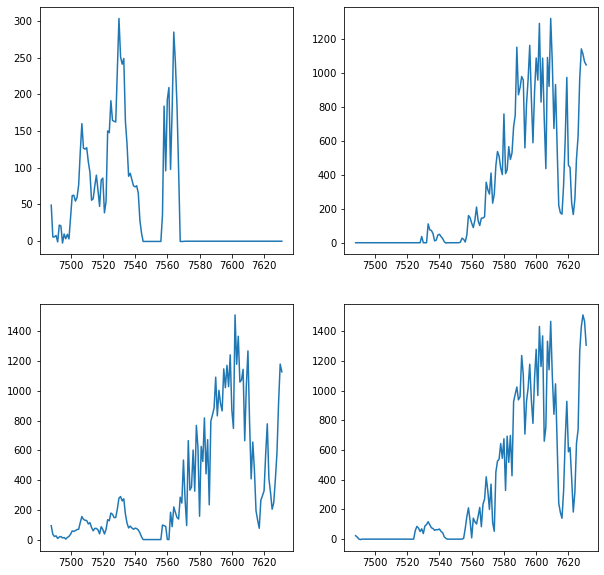

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 2) # 4 subplots
fig.set_size_inches(10,10) # set figure size

ax[0][0].plot(train_data[1][train_data[1].Day == 53].Patv)
ax[1][0].plot(train_data[4][train_data[4].Day == 53].Patv)
ax[0][1].plot(train_data[100][train_data[100].Day == 53].Patv)
ax[1][1].plot(train_data[120][train_data[120].Day == 53].Patv)
# Turbin마다 차이가 있지만 완전히 다르지는 않기 때문에 한 터빈의 변수만 확인하고 이를 전체로 확장함

### Variable

##### Wspd

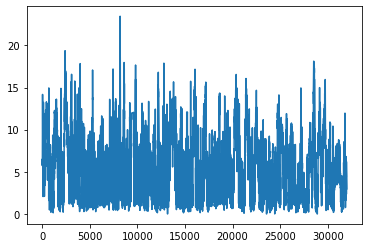

In [15]:
plt.plot(train_data[10].Wspd) #정상적인가?
# 높은 관측을 제외하면 정상일 수도 있을 것 같음
# 추세는 보이지 않고 오직 주기만?

<AxesSubplot:xlabel='Wspd', ylabel='Density'>

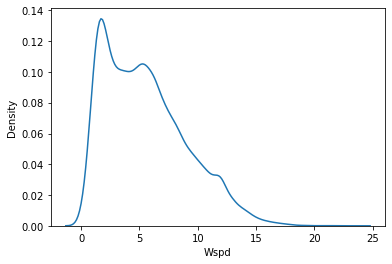

In [16]:
sns.kdeplot(train_data[10].Wspd) # 정규분포라고 보기는 힘듦
# 만약 바람 속도가 음수 값도 있었다면 정규 분포였을 수도 있을 것으로 보임

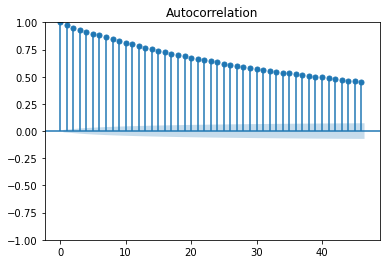

In [17]:
plot_acf(train_data[10].Wspd) 
plt.show()
#정상성을 갖지 않음

##### Prtv

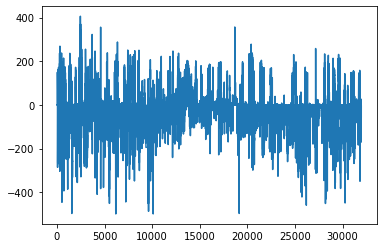

In [18]:
plt.plot(train_data[10].Prtv)

(array([5.4000e+01, 1.4400e+02, 4.5900e+02, 2.1700e+03, 6.2230e+03,
        1.8327e+04, 2.8790e+03, 1.6110e+03, 8.6000e+01, 1.5000e+01]),
 array([-499.91 , -409.272, -318.634, -227.996, -137.358,  -46.72 ,
          43.918,  134.556,  225.194,  315.832,  406.47 ]),
 <BarContainer object of 10 artists>)

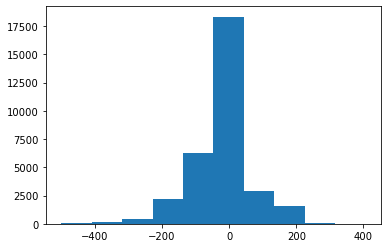

In [19]:
plt.hist(train_data[10].Prtv)
#대부분 0에 가깝고 몇 개의 이상치가 보임

##### Patv

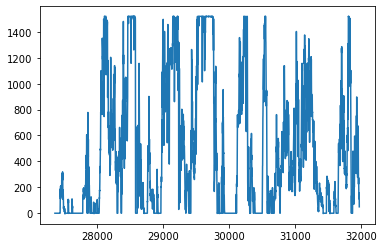

In [20]:
plt.plot(train_data[10][train_data[10].Day > 190].Patv) 
#특이값은 없는 듯하고 범위가 확실함
#추세는 없음

(array([12332.,  4503.,  3067.,  2317.,  1896.,  1523.,  1268.,  1281.,
         1087.,  2694.]),
 array([  -7.81 ,  145.119,  298.048,  450.977,  603.906,  756.835,
         909.764, 1062.693, 1215.622, 1368.551, 1521.48 ]),
 <BarContainer object of 10 artists>)

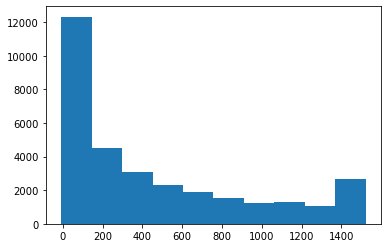

In [21]:
plt.hist(train_data[10].Patv)
# 이봉 분포 

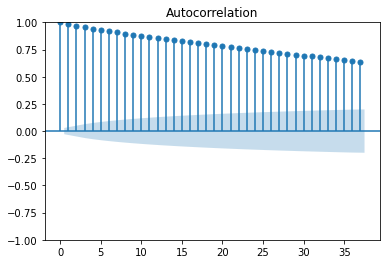

In [22]:
plot_acf(train_data[10][train_data[10].Day > 190].Patv)
plt.show()
# 역시 정상성을 갖는다고 보기 힘듦

# Correlation

<AxesSubplot:>

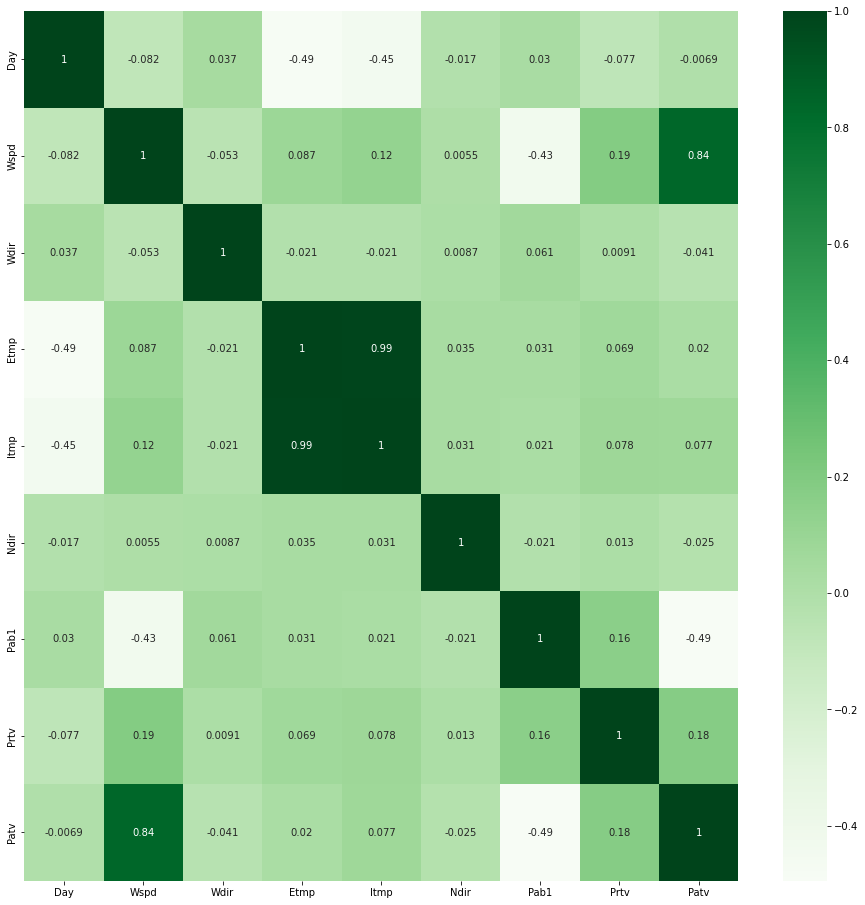

In [23]:
plt.figure(figsize = (16,16))
sns.heatmap(train_data[10].corr(), annot = True, cmap = 'Greens')

- __Wspd는 Patv와 매우 높은 상관 관계를 가짐.__   
- 온도는 하나로 합쳐도 상관없을 것 같음.  
- Pab도 역시 하나로 합쳐도 상관없을 것 같음.  
- Prtv 역시 Patv와 상관 관계가 있기는 한데 어차피 Wspd와도 관계가 있고 Wspd와 Patv와의 관계가 너무 높아 필요가 많지는 않아 보임.

# 발전소 상대 위치 좌표

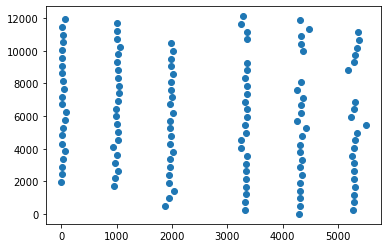

In [24]:
location = pd.read_csv("turb_location.csv")
plt.scatter(location["x"], location["y"])

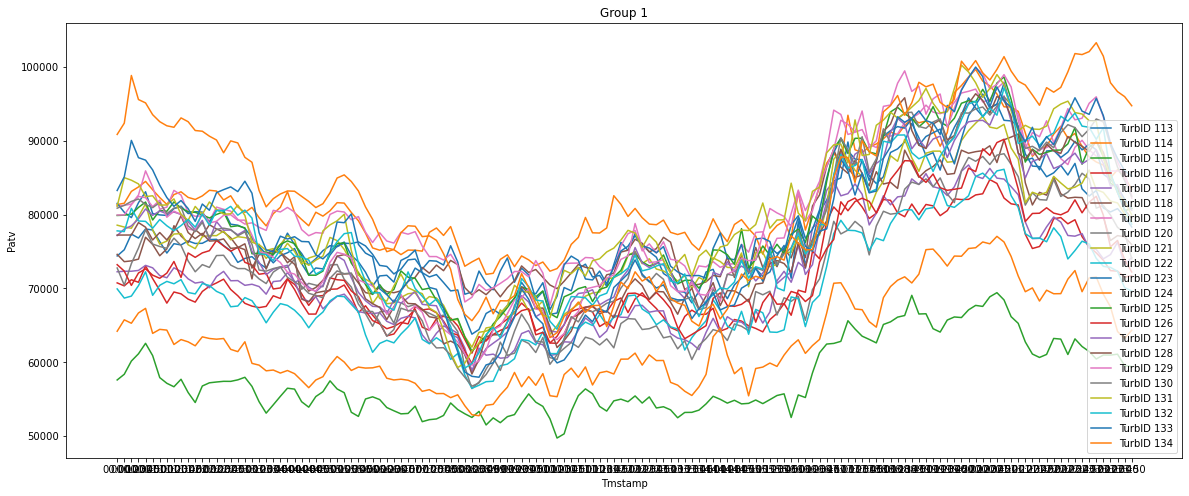

In [25]:
location1 = location[location["x"]<500]
group1=location1["TurbID"].values

time_patv = dacon.groupby(['TurbID', 'Tmstamp'], as_index=False)['Patv'].sum()

plt.figure(figsize=(20,8))

for i in group1 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 1')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

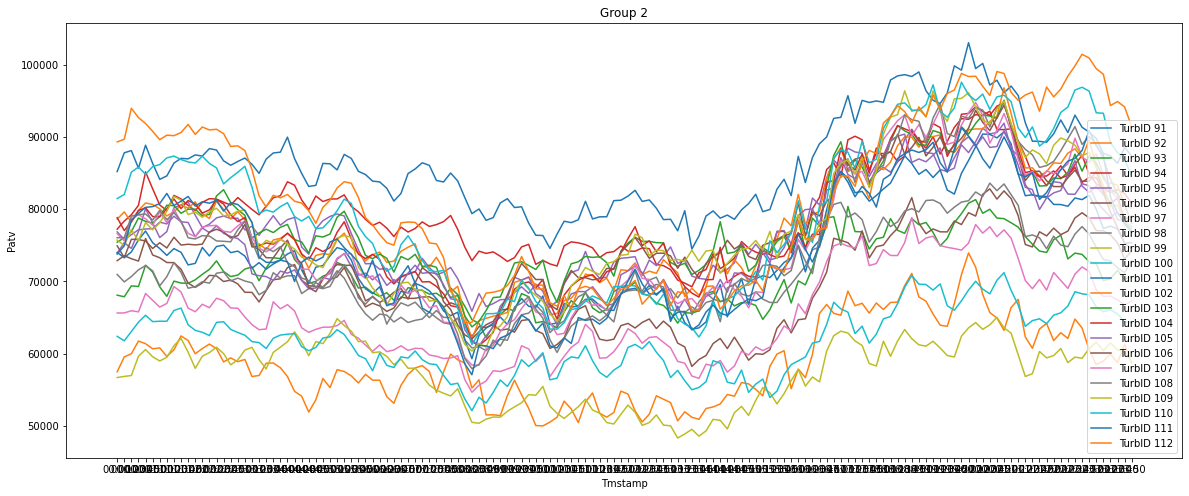

In [26]:
location2 = location[location["x"]<1500]
location2 = location2[location2["x"]>500]
group2=location2["TurbID"].values
plt.figure(figsize=(20,8))

for i in group2 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 2')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

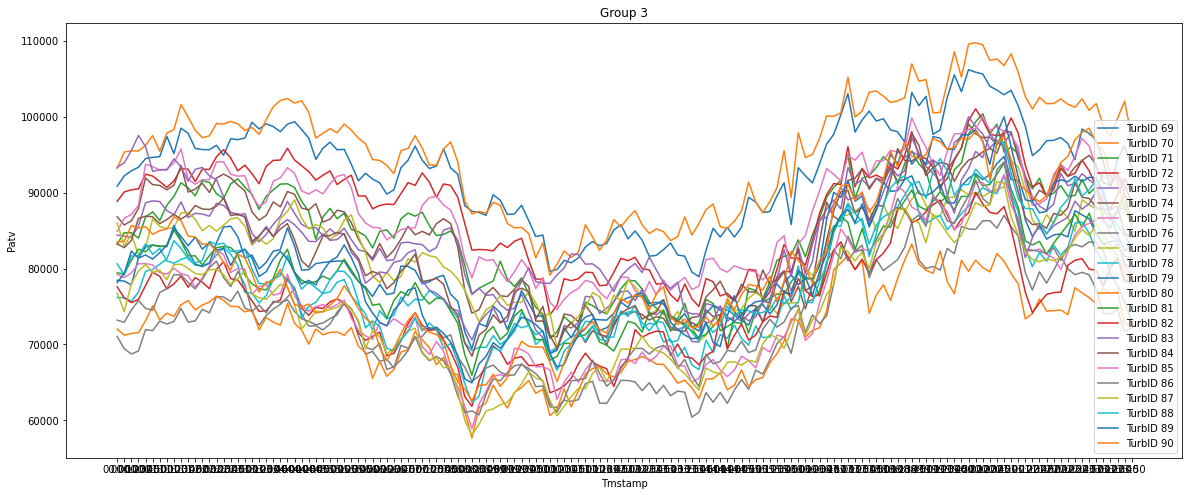

In [27]:
location3 = location[location["x"]<2500]
location3 = location3[location3["x"]>1500]
group3=location3["TurbID"].values
plt.figure(figsize=(20,8))

for i in group3 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 3')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

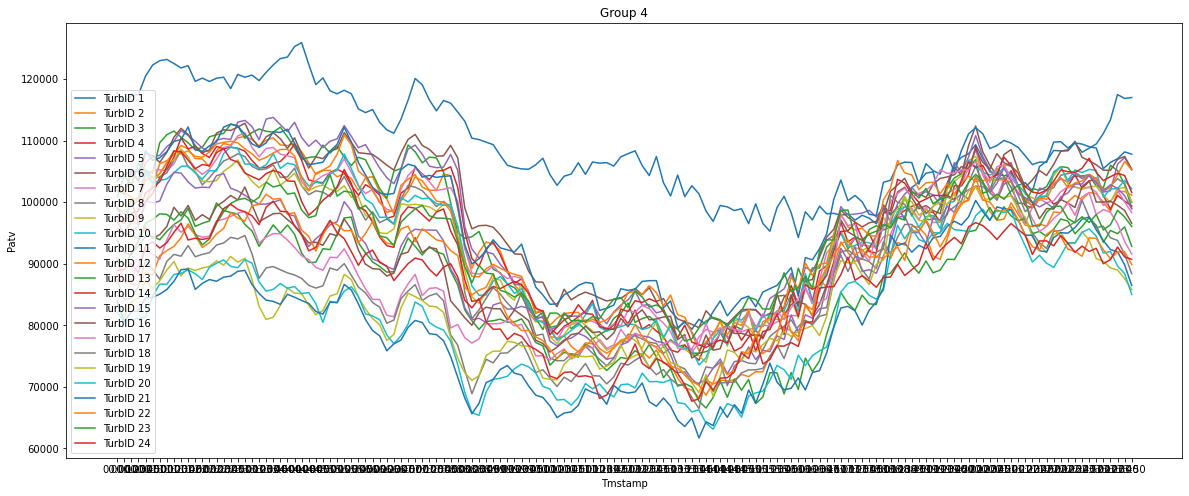

In [28]:
location4 = location[location["x"]<4000]
location4 = location4[location4["x"]>3000]
group4=location4["TurbID"].values
plt.figure(figsize=(20,8))

for i in group4 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 4')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

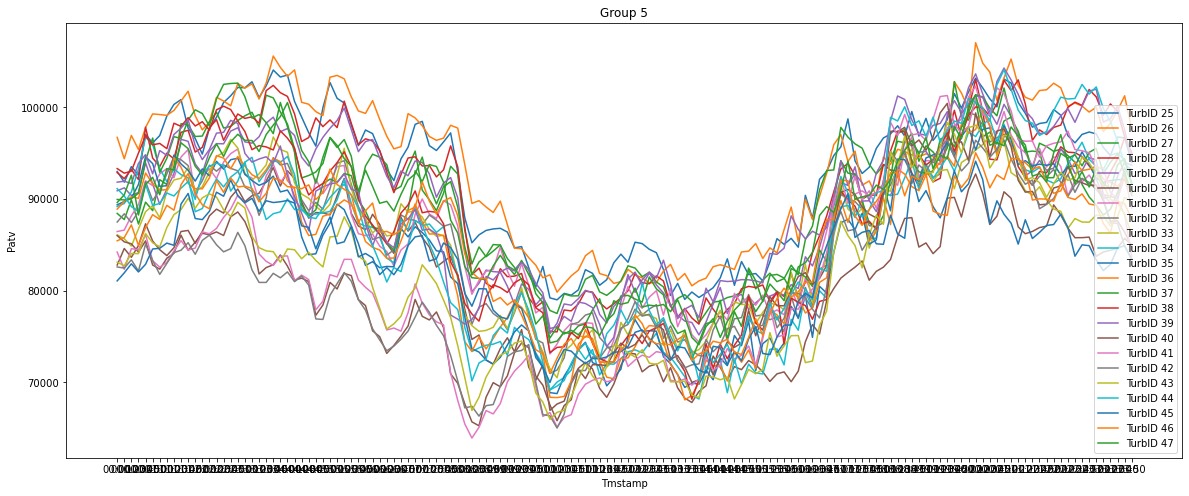

In [29]:
location5 = location[location["x"]<5000]
location5 = location5[location5["x"]>4000]
group5=location5["TurbID"].values
plt.figure(figsize=(20,8))

for i in group5 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 5')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

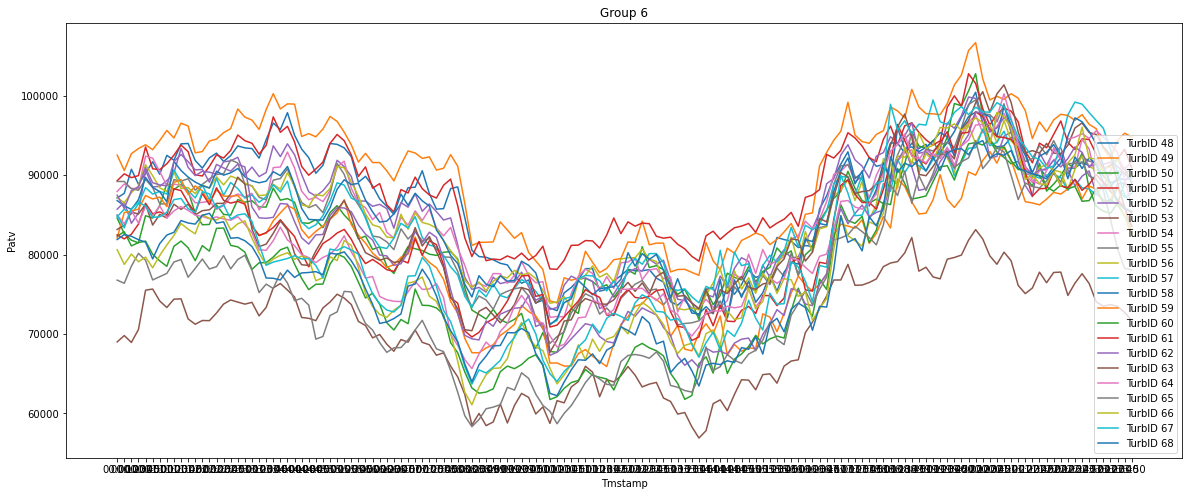

In [30]:
location6 = location[location["x"]>5000]
group6=location6["TurbID"].values
plt.figure(figsize=(20,8))

for i in group6 :
    temp = time_patv[time_patv.TurbID == i]
    plt.plot(temp['Tmstamp'], temp['Patv'], label = 'TurbID %d' % i)
    plt.title('Group 6')
    plt.xlabel('Tmstamp')
    plt.ylabel('Patv')
    plt.legend()

- 발전소 상대 위치 좌표를 바탕으로 터빈이 x좌표를 기준으로 크게 6가지 그룹으로 나누어짐을 확인함. 그룹별로 Tmstamp에 대한 patv값의 합이 비슷한 경향성을 띄지만, 유의미한 차이가 나지 않고 이를 적용한 모델의 성능 변화도 미미하여 사용하지 않음.